In [93]:
from cirq.contrib.svg import SVGCircuit
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error
from mnist import MNISTData

import scipy
import cirq
import numpy as np
import tensorflow_quantum as tfq
import tensorflow as tf

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [113]:
mnist_data = MNISTData(seed)
X_train, X_test, y_train, y_test = mnist_data.get_three_five_test_train_split()
train_indices = np.random.randint(0, X_train.shape[0], 1600)
test_indices = np.random.randint(0, X_test.shape[0], 400)

X_tr = X_train[train_indices]
y_tr = y_train[train_indices]
X_te = X_test[test_indices]
y_te = y_test[test_indices]
print(X_tr.shape, X_te.shape)

(12108, 784) (1346, 784)
(1600, 784) (400, 784)


In [159]:
class TwoQubitQks:
    def __init__(self, X_train, y_train, X_test, y_test, episodes=100):
        self.qubits = cirq.LineQubit.range(2)
        # the number of qubits
        self.q = 2
        self.p = X_train.shape[1]
        self.r = self.p/self.q
        self.E = episodes
        self.X_train = X_train
        self.y_train = y_train
        self.y_test = y_test
        self.X_test = X_test
        # mask = q * p
        mask = np.ones((self.q, self.p))
        mask[0,:int(self.r)], mask[1,int(self.r):] = 0.0, 0.0
        self.mask = mask.reshape(self.q*self.p)
    
    def _get_ansatz(self, theta, draw=False):
        circuit = cirq.Circuit()
        circuit.append(cirq.rx(theta[0])(self.qubits[0]))
        circuit.append(cirq.rx(theta[1])(self.qubits[1]))
        circuit.append(cirq.CNOT(self.qubits[0], self.qubits[1]))
        circuit.append(cirq.measure(self.qubits[1]))
        
        if draw:
            SVGCircuit(circuit)    
        return circuit
    
    def _get_meas(self, theta):
        circuit = self._get_ansatz(theta)
        result = cirq.Simulator().run(circuit)
        return -1 if result.measurements['1'][0][0] == 0 else 1
    
    def _get_omega_and_beta(self, variance):
        stddev = variance ** 2
        # mask = E x q x p
        mask = self.mask.repeat(self.E)
        # mask = (E x (q*p))
        mask = mask.reshape((self.E, self.q*self.p))
        # omega_e = (E x (q*p))
        omega_e = np.random.normal(0.0, stddev, (self.E, (self.q * self.p)))
        # omega = (mask * omega_e) so (E x (q*p))
        omega = mask * omega_e
        # omega = (E x p x q)
        omega = omega.reshape((self.E, self.p, self.q), order='F')
        # beta = (E x q)
        beta = np.random.uniform(0.0, 2 * np.pi, (self.E, self.q))
        return omega, beta
    
    def _get_embeddings(self, variance):
        omega, beta = self._get_omega_and_beta(variance)
        # params = (n x E x q)
        params = self.X_train.dot(omega) + beta
        # params = (n * E) x q
        return params.reshape((params.shape[0] * params.shape[1], params.shape[2]))
        
    def _loss(self, variance):
        # labels = (n * E)
        labels = np.tile(self.y_train, self.E)
        params = self._get_embeddings(variance)
        
        # get predictions
        preds = np.array([self._get_meas(param) for param in params])
        # get loss
        return mean_squared_error(preds, labels)
    
    def train(self):
        result = scipy.optimize.minimize_scalar(self._loss)
        self.variance = result['x']
        print(result)
        
    def test_accuracy(self):
        stddev = self.variance ** 2
        n = self.X_test.shape[0]
        omega = np.random.normal(0.0, stddev, (self.p, self.q)) * self.mask.reshape((self.p, self.q))
        beta = np.random.uniform(0.0, 2 * np.pi, (self.q,))
        
        params = self.X_test.dot(omega)
        preds = np.array([self._get_meas(param) for param in params])
        return (np.sum(preds == self.y_test)/preds.shape[0]) * 100

In [160]:
twoQubitQks = TwoQubitQks(X_tr, y_tr, X_te, y_te, episodes=5)

In [161]:
twoQubitQks._get_ansatz([np.pi, np.pi], draw=True)

0: ───Rx(π)───@───────
              │
1: ───Rx(π)───X───M───

In [ ]:
twoQubitQks.train()

In [150]:
twoQubitQks.test_accuracy()

(1568,)


55.50000000000001

In [131]:
# Declare a QKS layer that extends keras Layer
class TwoQubitQKSAnsatzLayer(tf.keras.layers.Layer):
    def __init__(self, qubits, uniform_min_value=0.0, uniform_max_value=2.0 * np.pi, stddev=0.1):
        super(TwoQubitQKSAnsatzLayer, self).__init__()
        self.q = 2 # because two qubits, variable names q, p, r are the same as in Wilson et al.
        self.stddev = tf.Variable(initial_value=stddev, trainable=True)
        self.uniform_min_value = 0.0
        self.uniform_max_value = 2.0 * np.pi
        self.qubits = qubits
    
    def build(self, input_shape):
        # creates a mask, which will stay contant throught
        p = input_shape[-1]
        self.r = int(p/self.q)
    
    def _ansatz(self, theta):
        print(float(theta[0]))
        # theta = theta.numpy()
        circuit = cirq.Circuit()
        circuit.append(cirq.rx(float(theta[0]))(self.qubits[0]))
        circuit.append(cirq.rx(float(theta[1]))(self.qubits[1]))
        circuit.append(cirq.CNOT(self.qubits[0], self.qubits[1]))
        
        circuit.append(cirq.measure(self.qubits[0]))
        circuit.append(cirq.measure(self.qubits[1]))
        return circuit
    
    def I(self):
        # just a Identity circuit for the PQC layer
        # when you create the model
        circuit = cirq.Circuit()
        circuit.append(cirq.I(self.qubits[0]))
        circuit.append(cirq.I(self.qubits[1]))
        return circuit
        
    def call(self, input):
        p = input.shape[-1]
        
        ones, mask = np.ones((self.q, p)), np.random.randint(0, 2, self.q)
        ones[mask==0,:self.r], ones[mask==1,self.r:] = 0.0, 0.0
        self.mask = ones.reshape((self.q, p))
        
        omega = tf.random.normal((self.q, p), mean=0.0, stddev=self.stddev) * self.mask
        beta = tf.random.uniform((self.q,), self.uniform_min_value, self.uniform_max_value)
        
        parameters = tf.linalg.matvec(omega, input) + beta
        return tfq.convert_to_tensor([self._ansatz(parameters)])

In [132]:
qubits = cirq.GridQubit.rect(1,2)
qks_ansatz = TwoQubitQKSAnsatzLayer(qubits)

In [133]:
qks_ansatz.trainable_variables

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>]

In [134]:
data = tf.random.normal((10,), mean=0.0, stddev=1.0)
qks_ansatz(data).shape

0.4427309036254883


TensorShape([1])

0.5


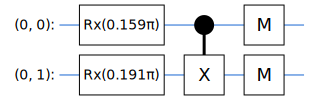

In [135]:
SVGCircuit(qks_ansatz._ansatz(tf.convert_to_tensor([0.5, 0.6])))

In [142]:
class QuantumKitchenSinks:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
    
    def _mnist_model_compile(self, learning_rate):
        cluster_state_bits = cirq.GridQubit.rect(1,2)
        readout_operators = [cirq.Z(cluster_state_bits[0]), cirq.Z(cluster_state_bits[1])]
        
        
        model = tf.keras.Sequential([
            TwoQubitQKSAnsatzLayer(qubits),
            tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
        ])
        
#         inputs = tf.keras.Input(shape=(784,), name="digits")
#         ansatz = TwoQubitQKSAnsatzLayer(qubits)
#         quantum_circuits = ansatz(inputs)
#         expectation_layer = tfq.layers.PQC(quantum_circuits.I(), readout_operators)
#         expec_outputs = expectation_layer(quantum_circuits)
#         outputs = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)(expec_outputs)
#         model = keras.Model(inputs=inputs, outputs=outputs)
        
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.categorical_crossentropy)
        # tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)
        self.mnist_model = model
    
    def mnist_model_fit(self, epochs=10, learning_rate=0.01, batch_size=500):
        self._mnist_model_compile(learning_rate=learning_rate)
        history = self.mnist_model.fit(x=self.X_train, y=self.y_train, epochs=epochs, batch_size=batch_size, verbose=1)
        plt.plot(history.history['loss'])
        plt.title("Binary Classification for MNIST data set on 0,1 digits")
        plt.xlabel("Iterations")
        plt.ylabel("Error in classification")
        plt.show()
        print("Final loss value:")
        print(history.history["loss"][-1])

In [143]:
tf.compat.v1.global_variables_initializer()
quantum_kitchen_sinks_model = QuantumKitchenSinks(X_train, X_test, y_train, y_test)

In [144]:
quantum_kitchen_sinks_model.mnist_model_fit()

Tensor("sequential_4/two_qubit_qks_ansatz_layer_31/strided_slice:0", shape=(2,), dtype=float32)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (tmpv8y6hvhs.py, line 16)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (tmpv8y6hvhs.py, line 16)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (tmps31j_5s3.py, line 16)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (tmps31j_5s3.py, line 16)
Please report this to th

TypeError: in converted code:

    <ipython-input-131-9a4db7340c07>:47 call  *
        return tfq.convert_to_tensor([self._ansatz(parameters)])
    /home/satya/code/quantum-machine-learning/quantum_machine_learning/lib/python3.6/site-packages/tensorflow_core/python/autograph/impl/api.py:292 wrapper
        return func(*args, **kwargs)
    /home/satya/code/quantum-machine-learning/quantum_machine_learning/lib/python3.6/site-packages/tensorflow_quantum/python/util.py:190 convert_to_tensor
        return tf.convert_to_tensor(recur(items_to_convert))
    /home/satya/code/quantum-machine-learning/quantum_machine_learning/lib/python3.6/site-packages/tensorflow_quantum/python/util.py:182 recur
        serializer.serialize_circuit(item).SerializeToString())
    /home/satya/code/quantum-machine-learning/quantum_machine_learning/lib/python3.6/site-packages/tensorflow_quantum/core/serialize/serializer.py:385 serialize_circuit
        circuit = copy.deepcopy(circuit_inp)
    /usr/lib/python3.6/copy.py:180 deepcopy
        y = _reconstruct(x, memo, *rv)
    /usr/lib/python3.6/copy.py:280 _reconstruct
        state = deepcopy(state, memo)
    /usr/lib/python3.6/copy.py:150 deepcopy
        y = copier(x, memo)
    /usr/lib/python3.6/copy.py:240 _deepcopy_dict
        y[deepcopy(key, memo)] = deepcopy(value, memo)
    /usr/lib/python3.6/copy.py:150 deepcopy
        y = copier(x, memo)
    /usr/lib/python3.6/copy.py:215 _deepcopy_list
        append(deepcopy(a, memo))
    /usr/lib/python3.6/copy.py:180 deepcopy
        y = _reconstruct(x, memo, *rv)
    /usr/lib/python3.6/copy.py:280 _reconstruct
        state = deepcopy(state, memo)
    /usr/lib/python3.6/copy.py:150 deepcopy
        y = copier(x, memo)
    /usr/lib/python3.6/copy.py:240 _deepcopy_dict
        y[deepcopy(key, memo)] = deepcopy(value, memo)
    /usr/lib/python3.6/copy.py:150 deepcopy
        y = copier(x, memo)
    /usr/lib/python3.6/copy.py:220 _deepcopy_tuple
        y = [deepcopy(a, memo) for a in x]
    /usr/lib/python3.6/copy.py:220 <listcomp>
        y = [deepcopy(a, memo) for a in x]
    /usr/lib/python3.6/copy.py:180 deepcopy
        y = _reconstruct(x, memo, *rv)
    /usr/lib/python3.6/copy.py:280 _reconstruct
        state = deepcopy(state, memo)
    /usr/lib/python3.6/copy.py:150 deepcopy
        y = copier(x, memo)
    /usr/lib/python3.6/copy.py:240 _deepcopy_dict
        y[deepcopy(key, memo)] = deepcopy(value, memo)
    /usr/lib/python3.6/copy.py:180 deepcopy
        y = _reconstruct(x, memo, *rv)
    /usr/lib/python3.6/copy.py:280 _reconstruct
        state = deepcopy(state, memo)
    /usr/lib/python3.6/copy.py:150 deepcopy
        y = copier(x, memo)
    /usr/lib/python3.6/copy.py:240 _deepcopy_dict
        y[deepcopy(key, memo)] = deepcopy(value, memo)
    /usr/lib/python3.6/copy.py:180 deepcopy
        y = _reconstruct(x, memo, *rv)
    /usr/lib/python3.6/copy.py:280 _reconstruct
        state = deepcopy(state, memo)
    /usr/lib/python3.6/copy.py:150 deepcopy
        y = copier(x, memo)
    /usr/lib/python3.6/copy.py:240 _deepcopy_dict
        y[deepcopy(key, memo)] = deepcopy(value, memo)
    /usr/lib/python3.6/copy.py:180 deepcopy
        y = _reconstruct(x, memo, *rv)
    /usr/lib/python3.6/copy.py:280 _reconstruct
        state = deepcopy(state, memo)
    /usr/lib/python3.6/copy.py:150 deepcopy
        y = copier(x, memo)
    /usr/lib/python3.6/copy.py:240 _deepcopy_dict
        y[deepcopy(key, memo)] = deepcopy(value, memo)
    /usr/lib/python3.6/copy.py:180 deepcopy
        y = _reconstruct(x, memo, *rv)
    /usr/lib/python3.6/copy.py:280 _reconstruct
        state = deepcopy(state, memo)
    /usr/lib/python3.6/copy.py:150 deepcopy
        y = copier(x, memo)
    /usr/lib/python3.6/copy.py:240 _deepcopy_dict
        y[deepcopy(key, memo)] = deepcopy(value, memo)
    /usr/lib/python3.6/copy.py:169 deepcopy
        rv = reductor(4)

    TypeError: can't pickle _thread.RLock objects
